In [17]:
import os
import sys

import time
import progressbar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline
plt.style.use('seaborn')

In [66]:
# config
BATCH_SIZE = 32
EPOCH = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [67]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    return X, y

In [20]:
def load_train_val_test_data(level, analyze=True):
    data_base_path = "../data/hierarchy/" + level
    train_sequences, train_labels = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
    val_sequences, val_labels = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
    test_sequences, test_labels = read_data_from_csv(os.path.join(data_base_path, "test.csv"))
    
    if analyze:
        a = list(map(lambda x: len(x), train_sequences))
        print("DNA Sequence Length Statistics:")
        print("Max:", np.max(a))
        print("Min:", np.min(a))
        print("Mean:", np.ceil(np.mean(a)))
        print("Median:", np.ceil(np.median(a)))
        print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))

    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [21]:
IMAGE_WIDTH = IMAGE_HEIGHT = 21  # 441 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [22]:
# analyze sequences to get the image size
train_sequences, train_labels, _, _, test_sequences, test_labels = load_train_val_test_data("phylum")

DNA Sequence Length Statistics:
Max: 440
Min: 400
Mean: 422.0
Median: 423.0
Sqrt of Max: 21.0


In [23]:
base_pair_colors = {
    (1, 0, 0, 0): [183, 28, 28],  # red
    (0, 1, 0, 0): [174, 234, 0],  # green
    (0, 0, 1, 0): [0, 145, 234],  # blue
    (0, 0, 0, 1): [255, 111, 0],  # orange
    (0, 0, 0, 0): [33, 33, 33]   # black
}

base_pair_char = {
    (1, 0, 0, 0): "A",
    (0, 1, 0, 0): "C",
    (0, 0, 1, 0): "G",
    (0, 0, 0, 1): "T",
    (0, 0, 0, 0): "X"
}

def viz_dna_image(dna_image, log=False):
    w, h, _ = dna_image.shape
    dna_rgb_image = np.zeros((w, h, 3))
    dna_char_image = np.empty((w, h), dtype="U10")
    for i, row in enumerate(dna_image):
        for j, col in enumerate(row):
            dna_rgb_image[i][j] = base_pair_colors[tuple(col)]
            dna_char_image[i][j] = base_pair_char[tuple(col)]
    plt.grid(b=None)

    if log:
        print("DNA Sequence:\n", dna_char_image.flatten())
        print("DNA Block:\n", dna_char_image)
        print("DNA QRCode:")
    plt.imshow(dna_rgb_image/255.0)

In [24]:
def create_pytorch_datasets(data, labels):
    tensor_x = torch.stack([torch.Tensor(np.swapaxes(i, 0, 2)) for i in data]) # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in labels]).long().view(-1)

    dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloader = utils.DataLoader(dataset, batch_size=BATCH_SIZE) # create your dataloader
    
    return dataloader

DNA Sequence:
 ['G' 'A' 'C' 'G' 'A' 'T' 'T' 'A' 'G' 'T' 'G' 'G' 'C' 'T' 'G' 'C']
DNA Block:
 [['G' 'A' 'C' 'G']
 ['A' 'T' 'T' 'A']
 ['G' 'T' 'G' 'G']
 ['C' 'T' 'G' 'C']]
DNA QRCode:


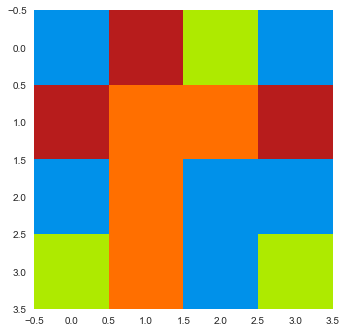

In [25]:
# Sample DNA Image Viz
sample_dna_sequence = "GACGATTAGTGGCTGC"
dna_image = np.array([base_pair_map[c] for c in list(sample_dna_sequence)]).reshape(4, 4, 4)
viz_dna_image(dna_image, log=True)

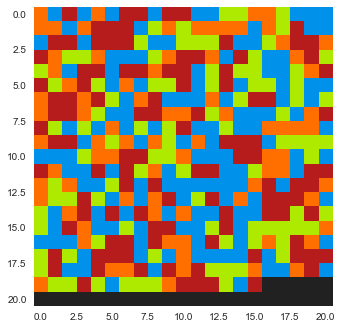

In [26]:
train_data = seqeunces_to_image(train_sequences)
viz_dna_image(train_data[0])

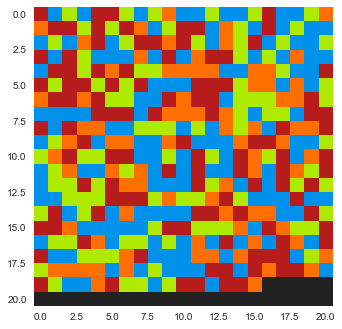

In [27]:
train_data = seqeunces_to_image(test_sequences)
viz_dna_image(train_data[0])

In [28]:
class SimpleCNN(nn.Module):

    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(16*32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool1(self.conv2(x)))
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return(x)

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = F.log_softmax(self.fc(out), dim=1)
        return out

In [35]:
# Print the CNN architecture
print(ConvNet(3))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=800, out_features=3, bias=True)
)


In [69]:
def cnn_train_model(model, train_loader, test_loader, optimizer, EPOCH):
    model = model.to(DEVICE)

    if DEVICE == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    t0 = time.perf_counter()

    loss_train = np.zeros((EPOCH,))
    loss_test = np.zeros((EPOCH,))
    acc_test = np.zeros((EPOCH,))
    acc_train = np.zeros((EPOCH,))
    time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(min_value=1, max_value=EPOCH)
    for epoch in range(EPOCH):
        bar.update(epoch+1)

        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').item()

        acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        for step, (x, y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

        loss_test[epoch] = test_loss/len(test_loader.dataset)
        acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        time_test[epoch] = time.perf_counter() - t0

    return [acc_train, acc_test, loss_train, loss_test]

In [71]:
def plot(acc_train, acc_test, loss_train, loss_test):
    print("Train Accuracy:", str(acc_train[-1]))
    print("Train Loss:", str(loss_train[-1]))
    print("Test Accuracy:", str(acc_test[-1]))
    print("Test Loss:", str(loss_test[-1]))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label='Acc. Train')
    plt.plot(acc_test, label='Acc. Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss_train, label='Loss Train')
    plt.plot(loss_test, label='Loss Test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
    plt.clf()

In [72]:
def cnn_train_test(level, model):
    # load train-test data and convert to a PyTorch Dataset of QRCode images
    train_sequences, train_labels, _, _, test_sequences, test_labels = load_train_val_test_data(level, analyze=False)
    train_loader = create_pytorch_datasets(seqeunces_to_image(train_sequences), train_labels)
    test_loader = create_pytorch_datasets(seqeunces_to_image(test_sequences), test_labels)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    logs = cnn_train_model(model, train_loader, test_loader, optimizer, EPOCH)
    plot(*logs)

100% (25 of 25) |########################| Elapsed Time: 0:01:51 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 3.847310882668162e-05
Test Accuracy: 99.29155313351498
Test Loss: 0.020989460971115072


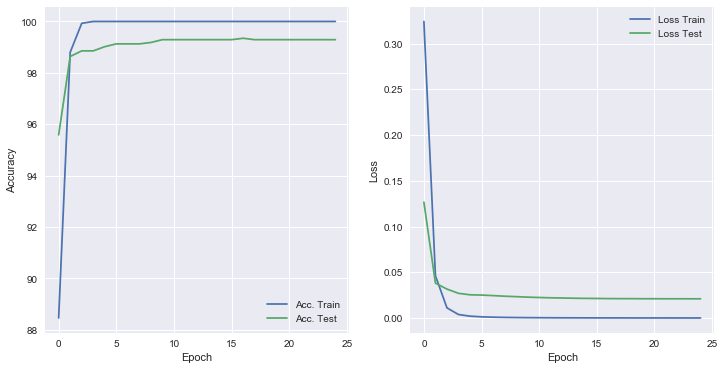

<Figure size 576x396 with 0 Axes>

In [73]:
cnn_train_test("phylum", ConvNet(3))

100% (25 of 25) |########################| Elapsed Time: 0:01:47 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.00017639812688494838
Test Accuracy: 98.85558583106267
Test Loss: 0.04878027734704499


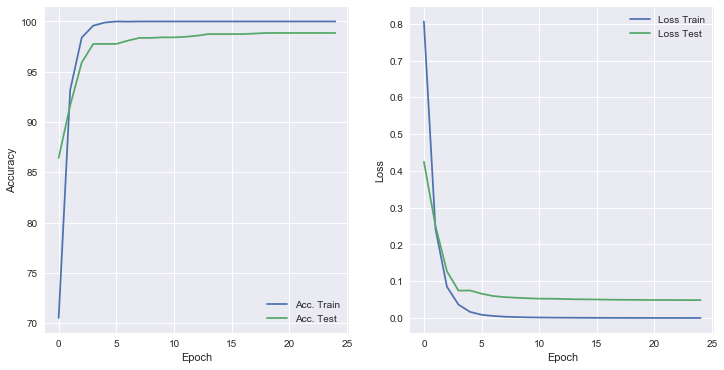

<Figure size 576x396 with 0 Axes>

In [74]:
cnn_train_test("class", ConvNet(5))

100% (25 of 25) |########################| Elapsed Time: 0:01:48 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.000775192950873874
Test Accuracy: 93.56948228882834
Test Loss: 0.21980527740083533


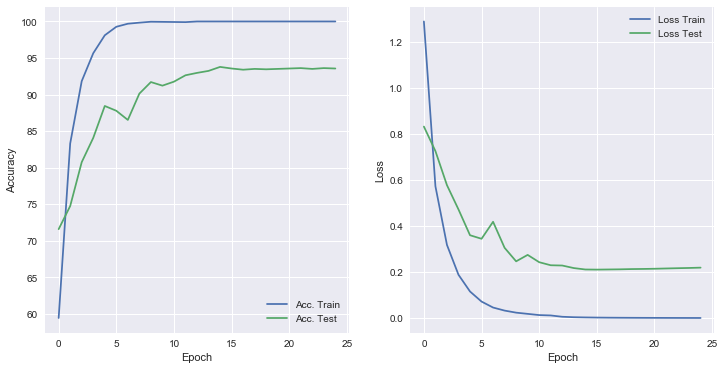

<Figure size 576x396 with 0 Axes>

In [75]:
cnn_train_test("order", ConvNet(10))